In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import 
import os
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor
from hmmlearn import hmm

In [3]:
from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch
#from uncertainty_motion_prediction.predictor import normalise_segment_batch


# Load the Dataset and Overview of the Data

Load and Data and conduct some brief analysis on the pattern of the normalised segment.

In [4]:
#Switch the dataset
'''
0: eth-univ
1: eth-hotel
2: ucy-zara1
3: ucy-zara2
4: ucy-univ3
'''
dataset_no = 4

In [5]:
dataset=Dataloader();
traj_dataset = dataset.load(dataset_no)

In [6]:
segment_length = 4
num_segment = 4# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

#Start by instantiating a HMM with continuous Gaussian emission distributions.
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length =num_segment * segment_length*0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(1798, 16, 5)


In [7]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])



In [8]:
#take a look at the data
df = pd.DataFrame(normalised)
df.describe()

,0,1,2,3,4,5,6,7
count,7192.0,7192.000000,7192.000000,7192.000000,7192.0,7192.000000,7192.000000,7192.000000
mean,0.0,-0.015634,-0.032226,-0.042826,0.0,-0.039751,-0.078832,-0.115764
std,0.0,0.219472,0.555339,0.960626,0.0,0.328302,0.754281,1.264929
min,0.0,-0.400001,-8.866977,-14.480140,0.0,-0.400002,-6.483671,-18.215998
25%,0.0,-0.170111,-0.317863,-0.459667,0.0,-0.377767,-0.689292,-1.030149
50%,0.0,-0.019442,-0.034363,-0.047232,0.0,-0.124984,-0.215739,-0.297313
75%,0.0,0.122521,0.228779,0.319476,0.0,0.351583,0.632408,0.931889
max,0.0,0.399999,7.878574,21.453562,0.0,0.400001,6.720954,23.015781


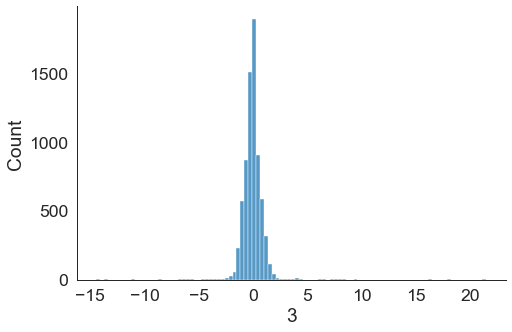

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df, x=3, kind="hist", bins = 100, aspect = 1.5)


/Users/lsw/opt/anaconda3/envs/PyCharm_Project/lib/python3.8/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


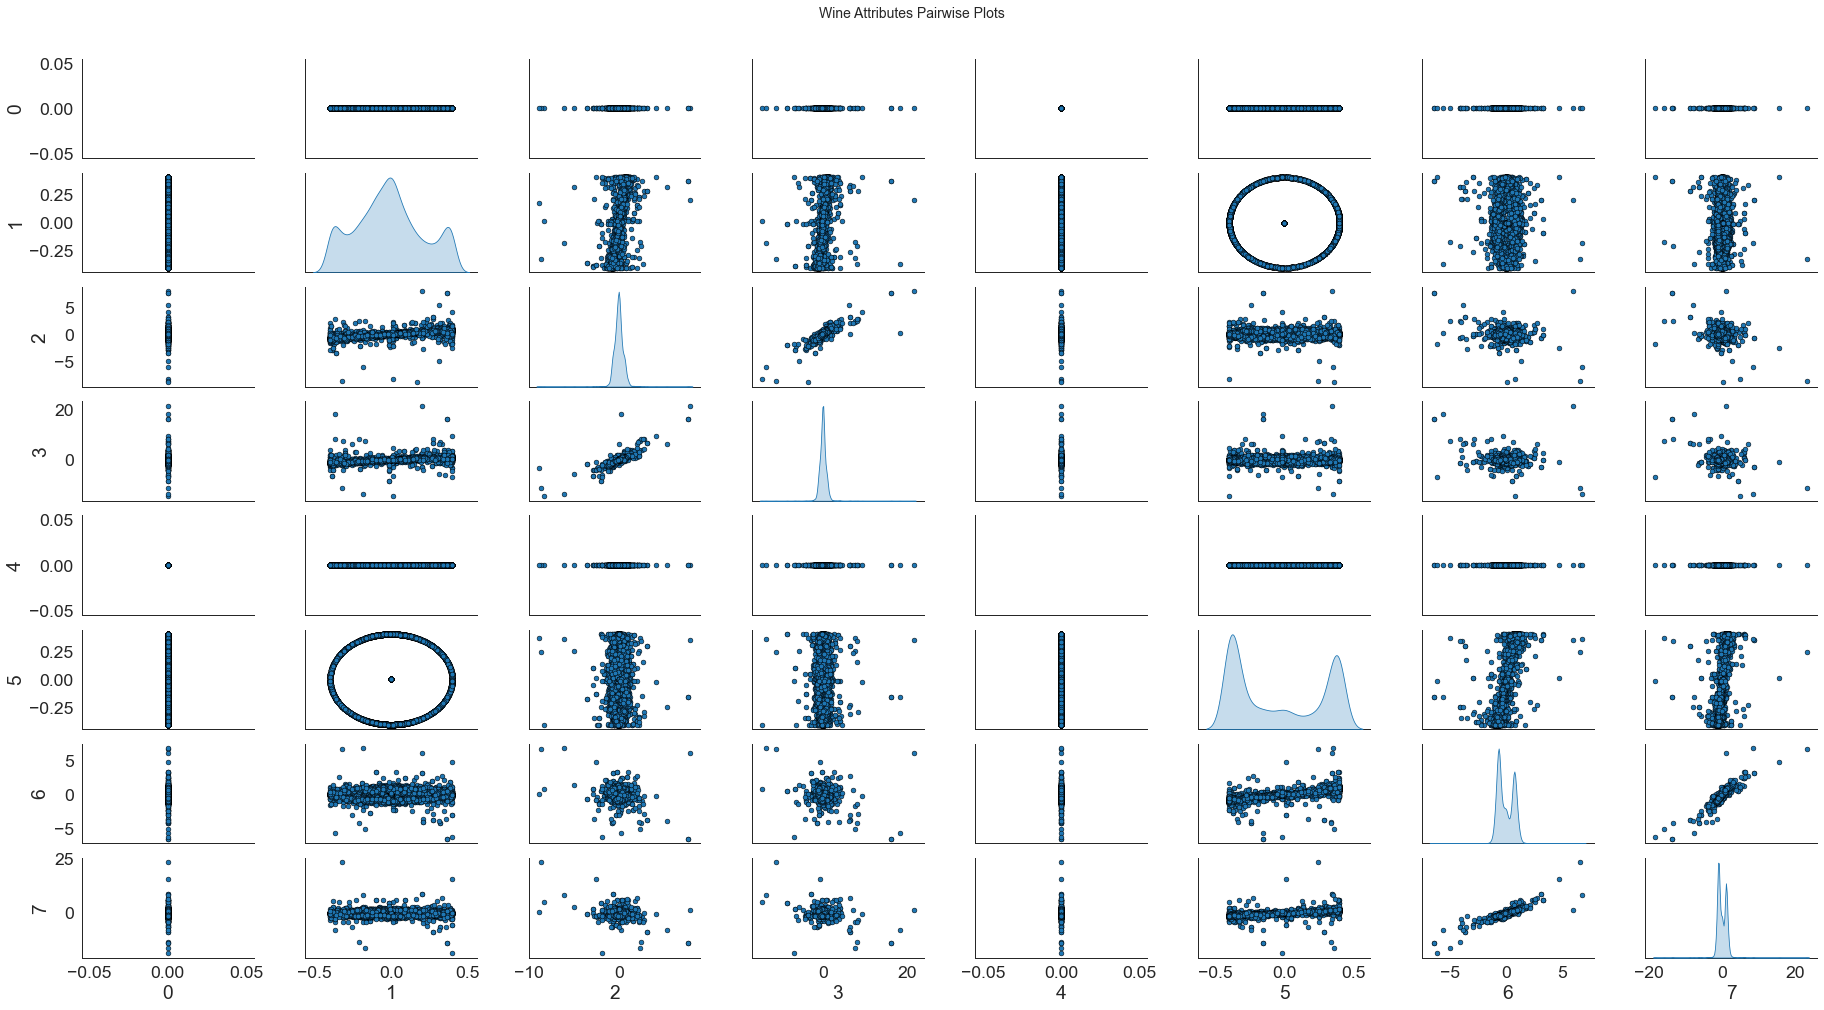

In [10]:
# Pair-wise Scatter Plots
pp = sns.pairplot(df, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)


# Hidden Markov Model with Gaussian emissions (to model trajectory observations)

Start by instantiating a HMM with continuous Gaussian emission distributions.

In [11]:
if dataset_no == 0:
    # ETC Uni
    n_components = 4
    covariance_type = "diag"
    n_iter = 30
elif dataset_no == 1:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 2:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 3:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50
elif dataset_no == 4:
    # ETC Hotel
    n_components = 4
    covariance_type = "diag"
    n_iter = 50


model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, verbose=True)

Preprocess the trajectories by normalising them (without the adjustment on Rotation). Then we estimate the model parameters (transition matrix and Gaussian emission distribution parameters).

In [12]:
trajlets_shape = trajlets_for_hmm_learning.shape
normalised = normalise_segment_batch(trajlets_for_hmm_learning[:, :, 0:4], segment_length)
sequence_lengths = np.array([num_segment for i in range(trajlets_shape[0])])

model.fit(normalised, lengths=sequence_lengths)

         1        2513.7483             +nan
         2       60661.9204      +58148.1721
         3       64709.4602       +4047.5398
         4       65354.1961        +644.7359
         5       65901.5715        +547.3754
         6       66535.1703        +633.5987
         7       67015.3154        +480.1451
         8       67480.9307        +465.6153
         9       68298.2734        +817.3427
        10       69123.3437        +825.0703
        11       69737.1128        +613.7690
        12       70148.4091        +411.2963
        13       70390.5387        +242.1297
        14       70530.8213        +140.2825
        15       70620.1299         +89.3086
        16       70675.2301         +55.1003
        17       70705.3033         +30.0732
        18       70719.6277         +14.3245
        19       70726.3039          +6.6762
        20       70729.5800          +3.2761
        21       70731.2566          +1.6766
        22       70732.1483          +0.8917
        23

GaussianHMM(n_components=4, n_iter=50, verbose=True)

In [13]:
import pickle
with open('gaussian_hmm_%s.pkl'%dataset_no, 'wb') as file:
    pickle.dump(model, file)


In [14]:
model.transmat_

array([[6.40264939e-01, 1.41018957e-01, 1.19148597e-01, 9.95675076e-02],
       [3.97643526e-02, 8.56390491e-01, 1.00824639e-01, 3.02051770e-03],
       [7.41227673e-02, 1.40083057e-01, 6.69104560e-01, 1.16689615e-01],
       [6.21386333e-02, 6.96613370e-04, 8.99641102e-02, 8.47200643e-01]])

Set up to test the model.

In [15]:
trajlets_for_testing = traj_dataset.get_trajlets(
    length=segment_length * num_segment * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(884, 16, 5)


A sanity check for our predictor and model, to visually inspect if the predict function works and yields reasonable values.

In [16]:
traj = trajlets_for_hmm_learning[0, :, :]

In [17]:
import pickle

model = None
with open('gaussian_hmm_%s.pkl'%dataset_no, 'rb') as file:
    model = pickle.load(file)
    
predictor = HMMContinuousEmissionsPredictor(hmm = model)
print(traj.shape)
print(predictor.predict(traj))

(16, 5)
[[-0.5426586   4.91837717]
 [-0.57362972  4.88856355]
 [-0.5426586   5.15602559]
 [-0.08786712  5.61794356]]


Compute the ADE and FDE of the model.

/Users/lsw/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/CS5340 Uncertainty Modelling in AI/05. GitRepo_LSW/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/Users/lsw/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/CS5340 Uncertainty Modelling in AI/05. GitRepo_LSW/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/Users/lsw/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/CS5340 Uncertainty Modelling in AI/05. GitRepo_LSW/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/Users/

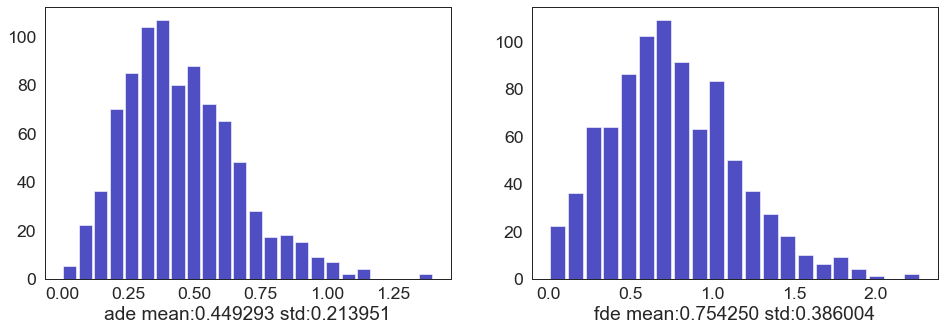

In [18]:
evaluator = DistanceErrorEvaluator(N_future=4)
evaluator.evaluate(predictor, trajlets_for_testing)
evaluator.hist()
res_state = evaluator.statistic()